## Step1: Initial Setting up

In [ ]:
# pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install --upgrade tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [4]:
!pip install --upgrade keras

In [5]:
!pip install seaborn

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from datasets import load_dataset
import seaborn as sns


ModuleNotFoundError: No module named 'sklearn'

## Load and Prepare Dataset

In [6]:
print("Loading dataset for 1000 samples...")

# Load dataset with streaming
dataset = load_dataset("huggan/wikiart", streaming=True)
dataset_iter = iter(dataset['train'])


genre_labels =  {
    0: 'abstract_painting', # renamed it as abstract 
	1: 'cityscape',
	2: 'genre_painting',
	3: 'illustration',
	4: 'landscape', 
	5: 'nude_painting',
	6: 'portrait', 
	7: 'religious_painting',  
	8: 'sketch_and_study',
	9: 'still_life',
	10: 'unknown_genre',
}

# Collect samples
images_1k = []
genres_1k = []
count_per_genre = {}

# Calculate minimum samples per genre (ensure at least 2 samples per class)
min_samples_per_genre = 2
target_per_genre = max(1000 // 11, min_samples_per_genre)  # 11 to account for potential uneven distribution

print("Loading data...")
try:
    while True:
        item = next(dataset_iter)
        genre = item['genre']
        
        # Initialize count for new genre
        if genre not in count_per_genre:
            count_per_genre[genre] = 0
            
        # Check if we need more samples of this genre
        if count_per_genre[genre] < target_per_genre:
            images_1k.append(item['image'])
            genres_1k.append(genre)
            count_per_genre[genre] += 1
            
        # Check if we have collected enough samples from all genres
        if all(count >= target_per_genre for count in count_per_genre.values()):
            break
            
except StopIteration:
    print("Reached end of dataset")

# Create DataFrame
df_1k = pd.DataFrame({
    'image': images_1k,
    'genre': genres_1k
})

# Print class distribution
print("\nClass distribution:")
print(df_1k['genre'].value_counts())

# Split data
train_df_1k, temp_df = train_test_split(
    df_1k, 
    test_size=0.3,
    stratify=df_1k['genre'],
    random_state=42
)

val_df_1k, test_df_1k = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['genre'],
    random_state=42
)

print(f"\nFinal splits:")
print(f"Training set: {len(train_df_1k)} samples")
print(f"Validation set: {len(val_df_1k)} samples")
print(f"Test set: {len(test_df_1k)} samples")


Loading dataset for 1000 samples...


Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading data...

Class distribution:
4     90
7     90
6     90
2     90
10    90
9     90
8     90
3     90
1     90
5     90
0     90
Name: genre, dtype: int64

Final splits:
Training set: 693 samples
Validation set: 148 samples
Test set: 149 samples


In [11]:
# Create a temporary directory to save images
import tempfile
temp_dir = tempfile.mkdtemp()
print(f"Created temporary directory: {temp_dir}")

#Load dataset with streaming
dataset = load_dataset("huggan/wikiart", streaming=True)
dataset_iter = iter(dataset['train'])

# Collect samples and save images
images_paths = []
genres = []
count_per_genre = {}
target_per_genre = max(1000 // 11, 2)  # Ensure at least 2 samples per class

print("Loading and saving images...")
try:
    while True:
        item = next(dataset_iter)
        genre = item['genre']
        
        if genre not in count_per_genre:
            count_per_genre[genre] = 0
            
        if count_per_genre[genre] < target_per_genre:
            # Save image to temporary file
            img = item['image']
            img_path = os.path.join(temp_dir, f"img_{len(images_paths)}.jpg")
            img.save(img_path)
            
            images_paths.append(img_path)
            genres.append(genre)
            count_per_genre[genre] += 1
            
        if all(count >= target_per_genre for count in count_per_genre.values()):
            break
            
except StopIteration:
    print("Reached end of dataset")

# Create DataFrame with image paths
df_1k = pd.DataFrame({
    'image': images_paths,
    'genre': genres
})

print("\nClass distribution:")
print(df_1k['genre'].value_counts())

# Split data
train_df_1k, temp_df = train_test_split(
    df_1k, 
    test_size=0.3,
    stratify=df_1k['genre'],
    random_state=42
)

val_df_1k, test_df_1k = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['genre'],
    random_state=42
)

print(f"\nFinal splits:")
print(f"Training set: {len(train_df_1k)} samples")
print(f"Validation set: {len(val_df_1k)} samples")

print(f"Test set: {len(test_df_1k)} samples")

Created temporary directory: /tmp/tmpbreixqvs


Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Loading and saving images...

Class distribution:
4     90
7     90
6     90
2     90
10    90
9     90
8     90
3     90
1     90
5     90
0     90
Name: genre, dtype: int64

Final splits:
Training set: 693 samples
Validation set: 148 samples
Test set: 149 samples


In [191]:
# distribution

# # Count occurrences of value 1 in column 'genre'
print(sorted(train_df_1k['genre'].value_counts()), '\n',
sorted(val_df_1k['genre'].value_counts()), '\n',
sorted(test_df_1k['genre'].value_counts()))

[63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63] 
 [13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14] 
 [13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14]


## Choose model ResNet50

In [ ]:
def create_model(num_classes, dropout_rate=0.5, use_batch_norm=True):
    # Load ResNet50 base model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    if use_batch_norm:
        x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    
    x = Dense(1024, activation='relu')(x)
    
    if use_batch_norm:
        x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    
    predictions = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=predictions)

In [214]:

# Cell 3: Create Data Generators
# Basic augmentation

genre_labels =  {
    0: 'abstract_painting', # renamed it as abstract 
	1: 'cityscape',
	2: 'genre_painting',
	3: 'illustration',
	4: 'landscape', 
	5: 'nude_painting',
	6: 'portrait', 
	7: 'religious_painting',  
	8: 'sketch_and_study',
	9: 'still_life',
	10: 'unknown_genre',
}	

train_df_1k['genre_label'] = list(map(lambda x: genre_labels[x], train_df_1k['genre']))
val_df_1k['genre_label'] = list(map(lambda x: genre_labels[x], val_df_1k['genre']))
test_df_1k['genre_label'] = list(map(lambda x: genre_labels[x], test_df_1k['genre']))

basic_datagen = ImageDataGenerator(
    rescale=1./255
)

# Augmentation with RandomFlip
flip_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

# Augmentation with RandomFlip and RandomRotation
flip_rotate_datagen = ImageDataGenerator(
    rescale=1./255,
    # horizontal_flip=True, 
    # vertical_flip=True,
    rotation_range=10   #30
)

# Create generators with directory specified
train_generator = flip_rotate_datagen.flow_from_dataframe(
    dataframe=train_df_1k,
    directory=None,  # Since we're using full paths
    x_col='image',
    y_col='genre_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    validate_filenames=False  # Add this to prevent file checking
)


val_generator = basic_datagen.flow_from_dataframe(
    dataframe=val_df_1k,
    directory=None,
    x_col='image',
    y_col='genre_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    validate_filenames=False
)

test_generator = basic_datagen.flow_from_dataframe(
    dataframe=test_df_1k,
    directory=None,
    x_col='image',
    y_col='genre_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    validate_filenames=False
)

# Print generator information
print("\nClass indices:")
print(train_generator.class_indices)
print(f"\nNumber of classes: {len(train_generator.class_indices)}")


Found 693 non-validated image filenames belonging to 11 classes.
Found 148 non-validated image filenames belonging to 11 classes.
Found 149 non-validated image filenames belonging to 11 classes.

Class indices:
{'abstract_painting': 0, 'cityscape': 1, 'genre_painting': 2, 'illustration': 3, 'landscape': 4, 'nude_painting': 5, 'portrait': 6, 'religious_painting': 7, 'sketch_and_study': 8, 'still_life': 9, 'unknown_genre': 10}

Number of classes: 11


In [ ]:
# Cell 4: Create and Train Model
# Base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

from tensorflow.keras.layers import Flatten
x = Flatten()(x) # adding the flatten to connect to the dense network 

x = Dropout(0.5)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    verbose=1
)


/home/guangyujiang/anaconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.1438 - loss: 3.5244 - val_accuracy: 0.0946 - val_loss: 2.8716
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.2213 - loss: 2.8590 - val_accuracy: 0.1081 - val_loss: 2.6820
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.2785 - loss: 2.5303 - val_accuracy: 0.1081 - val_loss: 2.6422
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3290 - loss: 2.2729 - val_accuracy: 0.1081 - val_loss: 2.5320
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.2752 - loss: 2.4053 - val_accuracy: 0.1216 - val_loss: 2.4801
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.3245 - loss: 2.1913 - val_accuracy: 0.1284 - val_loss: 2.4112
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3362 - loss: 2.0816 - val_accuracy: 0.2027 - val_loss: 2.3604
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.3800 - loss: 2.0218 - val_accuracy: 0.2027 - val_loss:

In [ ]:
# # Add custom layers
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# x = Dense(1024, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  


AttributeError: 'bool' object has no attribute 'astype'

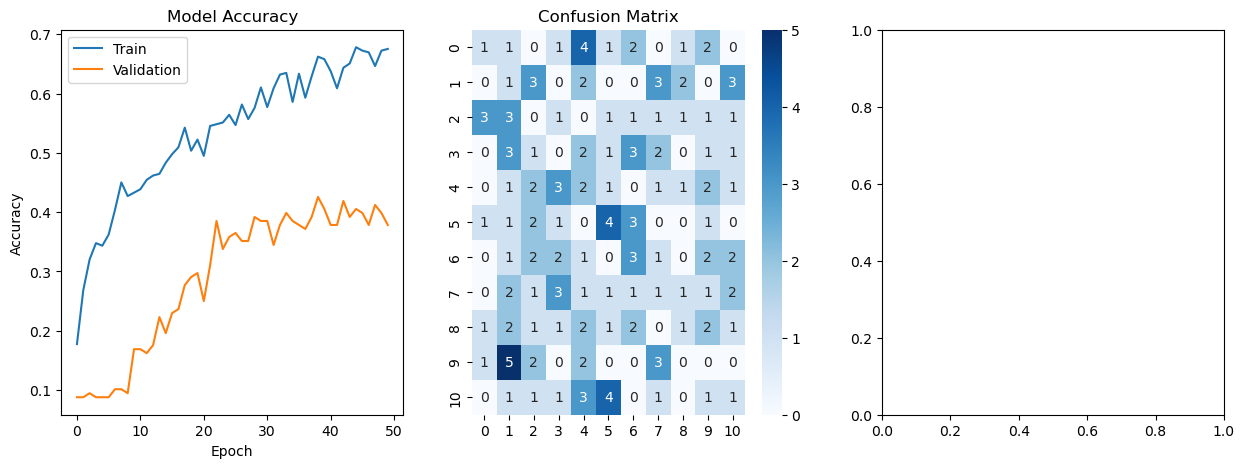

In [213]:
# Cell 5: Evaluate Model
# Get predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Plot results
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Confusion matrix
plt.subplot(1, 3, 2)
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

# ROC curve
plt.subplot(1, 3, 3)
n_classes = len(train_generator.class_indices)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

In [ ]:
# Cell 6: Try Different Learning Rates
learning_rates = [0.01, 0.001, 0.0001]

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    
    # Compile model with new learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,  # Reduced epochs for quick testing
        verbose=1
    )
    
    # Plot accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy (LR={lr})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()


In [ ]:
# Cell 7: Try Different Batch Sizes
batch_sizes = [16, 32, 64]

for bs in batch_sizes:
    print(f"\nTraining with batch size: {bs}")
    
    # Update generators
    train_generator.batch_size = bs
    val_generator.batch_size = bs
    
    # Reset and compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        verbose=1
    )
    
    # Plot accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy (Batch Size={bs})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [28]:
# train_df_1k['genre']
dataset['train']

IterableDataset({
    features: ['image', 'artist', 'genre', 'style'],
    n_shards: 72
})

In [92]:
# image and genre visualization
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# np.unique(np.array(genres_1k))
genre_idx = 0
test_idxs = np.where(np.array(genres_1k) == genre_idx)[0]
test_idx = np.where(np.array(genres_1k) == genre_idx)[0][0]
print(np.where(np.array(genres_1k) == genre_idx), 
      '\n Selected index image: ',  test_idx)

# Create a slider
slider = widgets.IntSlider(
    value=0,  # Initial value
    min=0,
    max=10,
    step=1,
    description= f'{genre_labels[genre_idx]}'
)

def update_img(w = 0):
    print('index', test_idxs[w])
    plt.imshow(images_1k[test_idxs[w]])

interact(update_img, w = slider);

(array([872, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912,
       913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925,
       926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938,
       939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951,
       952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964,
       965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977,
       978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989]),) 
 Selected index image:  872


interactive(children=(IntSlider(value=0, description='abstract_painting', max=10), Output()), _dom_classes=('w…

In [203]:
# building a new columns for categorical column
train_df_1k['genre_label'] = list(map(lambda x: genre_labels[x], train_df_1k['genre']))
train_df_1k

,image,genre,genre_label
685,/tmp/tmpbreixqvs/img_685.jpg,5,nude_painting
670,/tmp/tmpbreixqvs/img_670.jpg,7,religious_painting
19,/tmp/tmpbreixqvs/img_19.jpg,3,illustration
528,/tmp/tmpbreixqvs/img_528.jpg,10,unknown_genre
524,/tmp/tmpbreixqvs/img_524.jpg,8,sketch_and_study
...,...,...,...
610,/tmp/tmpbreixqvs/img_610.jpg,8,sketch_and_study
848,/tmp/tmpbreixqvs/img_848.jpg,5,nude_painting
536,/tmp/tmpbreixqvs/img_536.jpg,9,still_life
897,/tmp/tmpbreixqvs/img_897.jpg,5,nude_painting


In [116]:
train_generator = flip_rotate_datagen.flow_from_dataframe(
    dataframe=train_df_1k,
    directory=None,  # Since we're using full paths
    x_col='image',
    y_col='genre_label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    validate_filenames=False  # Add this to prevent file checking
)

Found 693 non-validated image filenames belonging to 11 classes.


In [132]:
import  cv2 

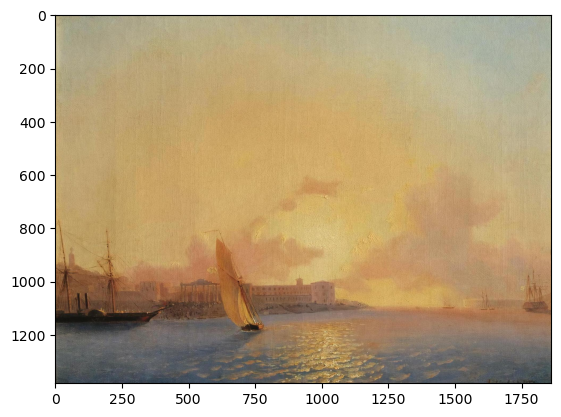

In [135]:
plt.imshow(cv2.imread('/tmp/tmpbreixqvs/img_528.jpg')[:,:,::-1])